In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from scipy.signal import convolve2d


In [4]:
#Load images

snrImg = []
snrReconstruct = []

rootNoisy = "gr5/Noisy"
noisyImgs = glob.glob(f"{rootNoisy}/*.bmp") + glob.glob(f"{rootNoisy}/*.jpg") 

rootOriginal = "gr5/Original"
originalImgs = glob.glob(f"{rootOriginal}/*.bmp") + glob.glob(f"{rootOriginal}/*.jpg")

originalImgs.sort()
noisyImgs.sort()

10463.358643867983
0.55048033432858


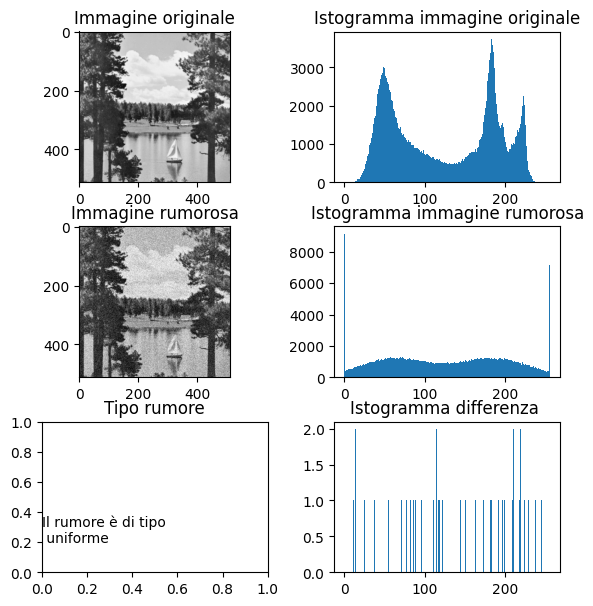

13038.828633936522
1.522336233118404


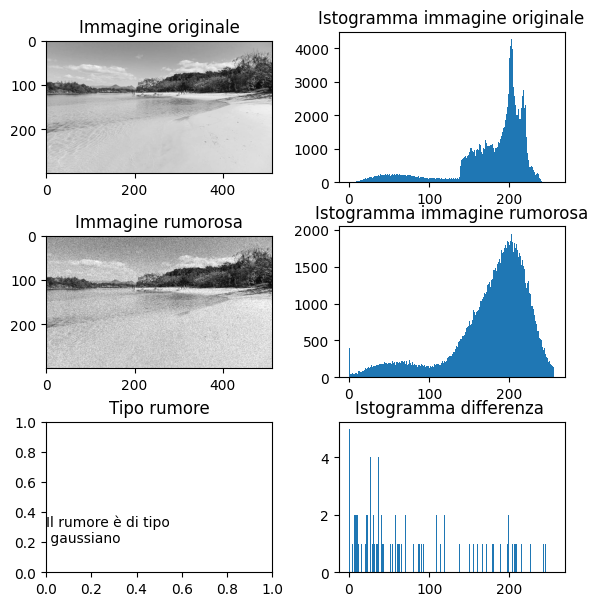

14365.19389408169
2.5924212216476397


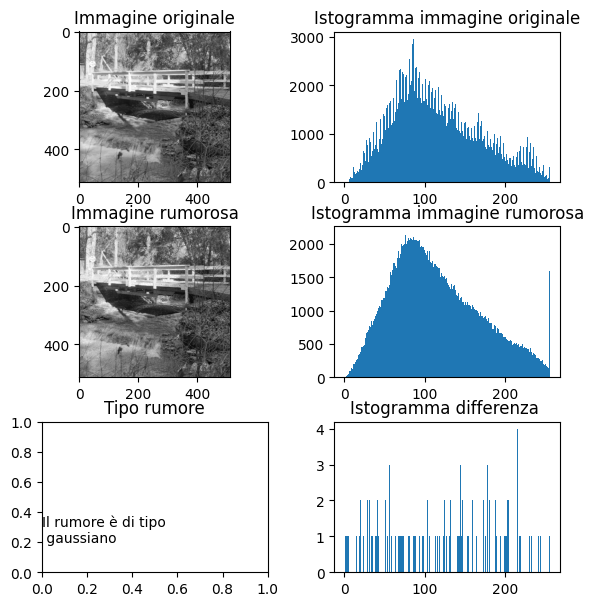

9605.14987436354
0.3920329629922808


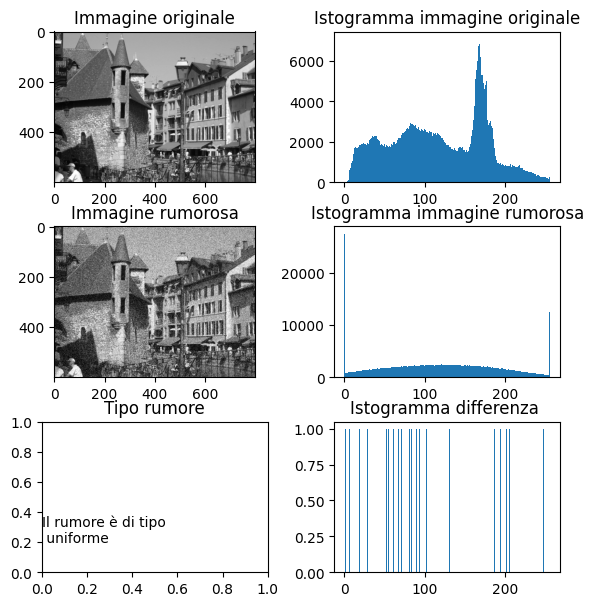

9475.745242877185
0.2820596766959912


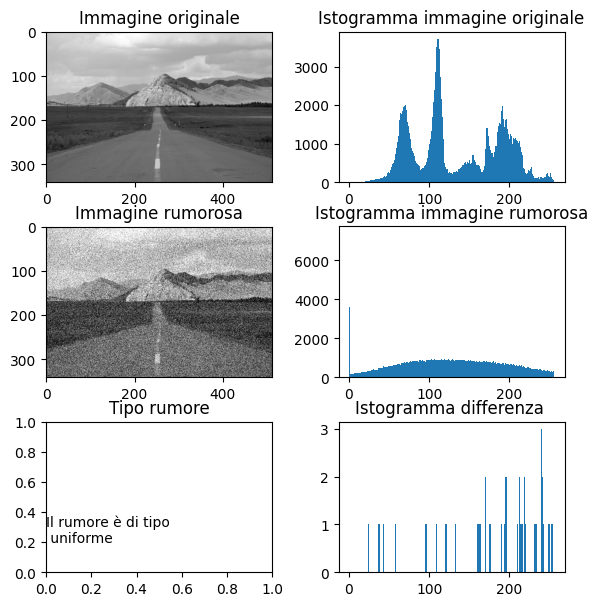

222.4022237475583
20.130873541463927


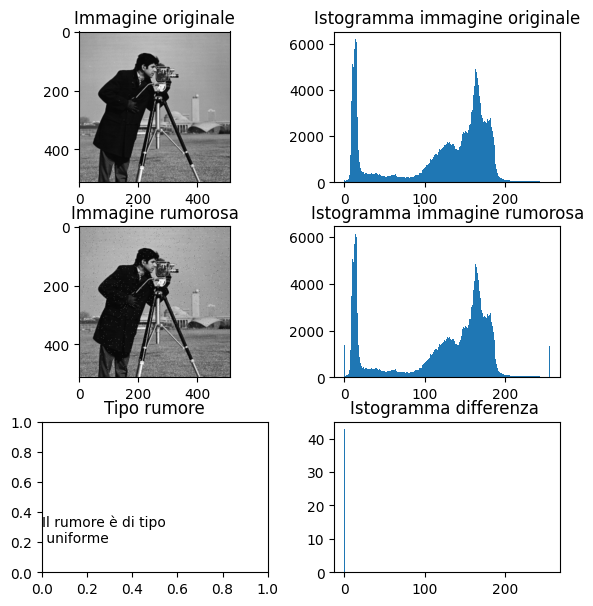

1209.8768330140592
13.136446482622704


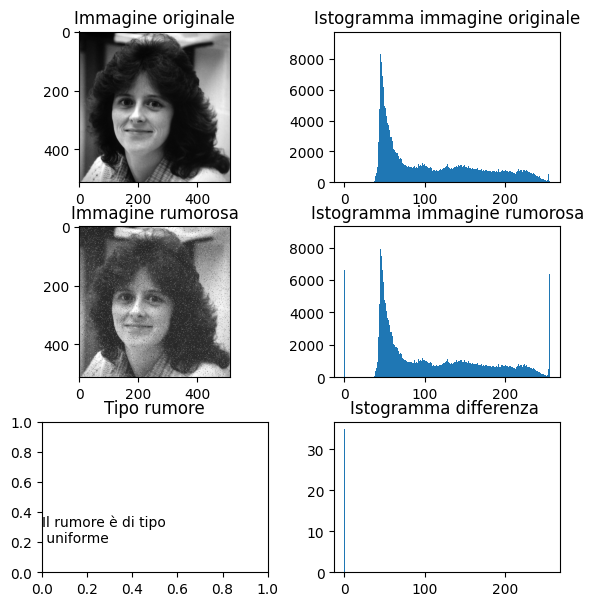

2954.4820761149354
6.949602664394018


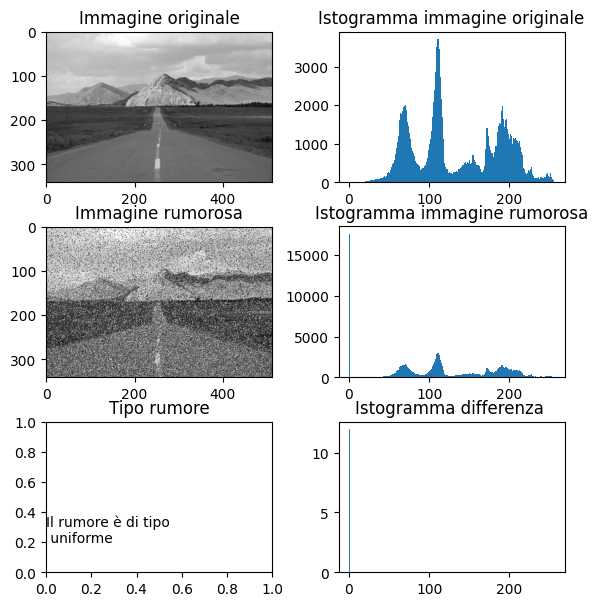

2623.6605935925004
7.010277078939717


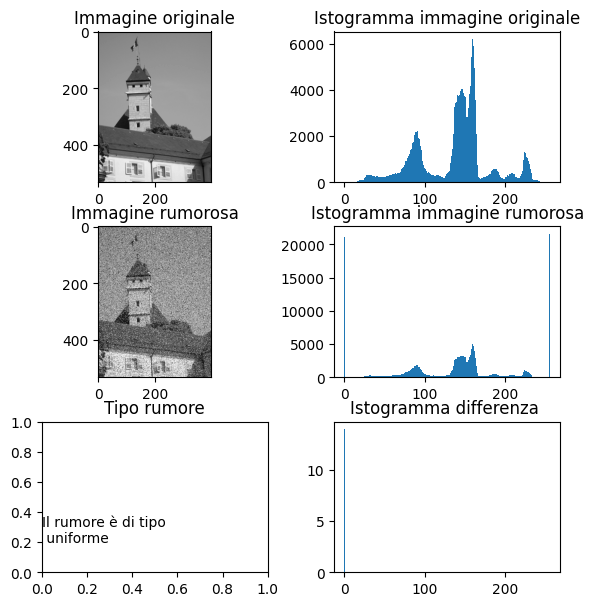

14354.5112277969
2.7443039844140014


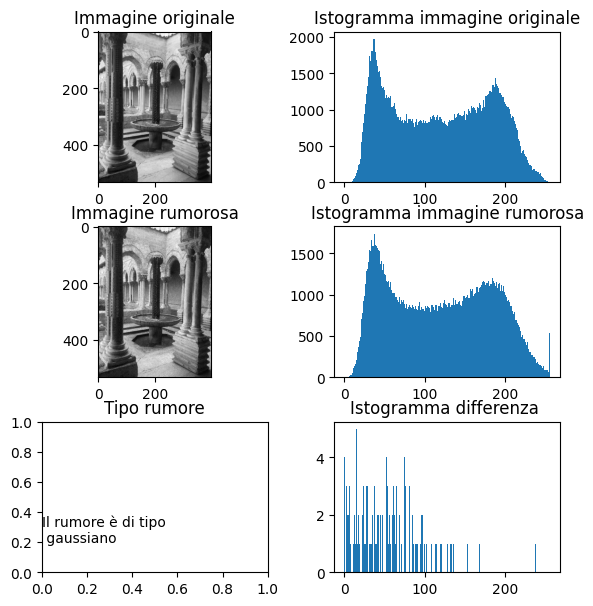

In [5]:
for i in range(len(originalImgs)):
    imgOriginal = cv2.imread(originalImgs[i],0)
    imgNoisy = cv2.imread(noisyImgs[i],0)

    histOrig, bins = np.histogram(imgOriginal.ravel(), bins=256, range=(0, 255))
    histNoise, bins = np.histogram(imgNoisy.ravel(), bins=256, range=(0, 255))

    histNoiseOnly = histNoise - histOrig

    imgNoiseOnly = imgNoisy - imgOriginal


    mean_sq_err = np.mean(imgNoiseOnly**2)
    snr = 10 * np.log10(np.mean(imgOriginal**2) / mean_sq_err)

    variance = np.var(imgNoiseOnly)
    noiseType = ""
    print(variance)
    if variance < 12000:
        noiseType = 'Il rumore è di tipo\n uniforme'
    elif variance >= 12000 and variance < 15000:
        noiseType ='Il rumore è di tipo\n gaussiano'
    elif variance >= 15000:
        noiseType ='Il rumore è di tipo\n impulsivo (sale e pepe)'

    print(snr)
    snrImg.append(snr)
    
    fig, axes = plt.subplots(3,2,figsize=(6,6))
    fig.tight_layout()
    axes[0][0].imshow(imgOriginal, cmap="gray")
    axes[0][0].set_title(f"Immagine originale")

    axes[0][1].hist(imgOriginal.ravel(),256,[0,256])
    axes[0][1].set_title(f"Istogramma immagine originale")

    axes[1][0].imshow(imgNoisy, cmap="gray")
    axes[1][0].set_title(f"Immagine rumorosa")

    axes[1][1].hist(imgNoisy.ravel(),256,[0,256])
    axes[1][1].set_title(f"Istogramma immagine rumorosa")

    axes[2][0].text(0, 0.2, noiseType)
    axes[2][0].set_title(f"Tipo rumore")

    axes[2][1].hist(histNoiseOnly,256,[0,256])
    axes[2][1].set_title(f"Istogramma differenza ")

    plt.show()


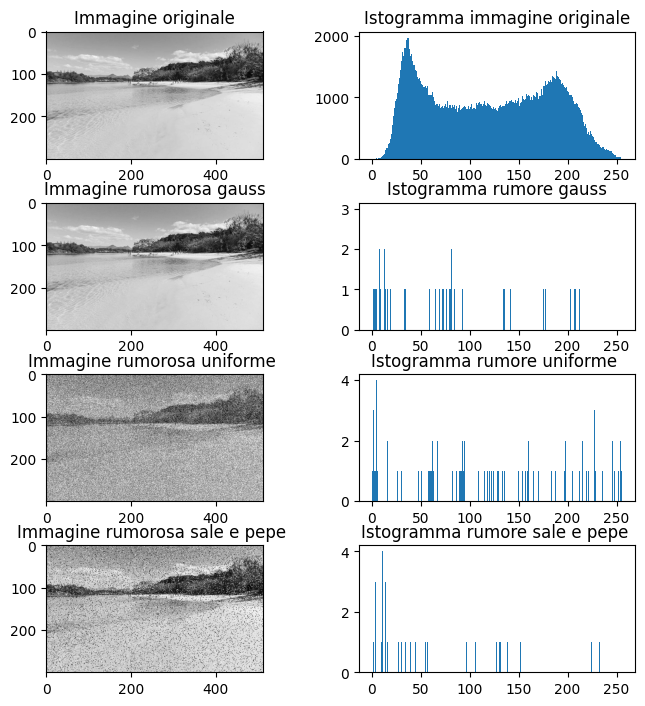

In [6]:
#presa un immagine definisco i tipi di rumore

img = cv2.imread(originalImgs[1],0)
#np.random.seed(42)

#Rumore gaussiano
noise = np.random.normal(size=img.shape)
imgNoisyGauss = img + noise
imgNoisyGauss = cv2.normalize(imgNoisyGauss, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

histOrig, bins = np.histogram(imgOriginal.ravel(), bins=256, range=(0, 255))

histNoise, bins = np.histogram(imgNoisyGauss.ravel(), bins=256, range=(0, 255))

histNoiseOnlyGauss = histNoise - histOrig

#Rumore uniforme
low = 0
high = 255
noise = np.random.uniform(low, high, img.shape)
#noise = np.random.rand(*img.shape) * 255
imgNoisyUni = img + noise
imgNoisyUni = cv2.normalize(imgNoisyUni, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

histNoise, bins = np.histogram(imgNoisyUni.ravel(), bins=256, range=(0, 255))

histNoiseOnlyUnif = histNoise - histOrig

#Rumore sale e pepe
x,y = img.shape
noise = np.random.rand(x,y)*255
salt = noise > 240
pepper = noise < 15
imgNoisySandP = img.copy()
imgNoisySandP[salt] = 255
imgNoisySandP[pepper] = 0
imgNoisySandP = cv2.normalize(imgNoisySandP, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

histNoise, bins = np.histogram(imgNoisySandP.ravel(), bins=256, range=(0, 255))

histNoiseOnlySandP = histNoise - histOrig

#matplot delle immagini con istogrammi
fig, axes = plt.subplots(4,2,figsize=(7,7))
fig.tight_layout()
axes[0][0].imshow(img, cmap="gray")
axes[0][0].set_title(f"Immagine originale")

axes[0][1].hist(imgOriginal.ravel(),256,[0,256])
axes[0][1].set_title(f"Istogramma immagine originale")

axes[1][0].imshow(imgNoisyGauss, cmap="gray")
axes[1][0].set_title(f"Immagine rumorosa gauss")

axes[1][1].hist(histNoiseOnlyGauss,256,[0,256])
axes[1][1].set_title(f"Istogramma rumore gauss")

axes[2][0].imshow(imgNoisyUni, cmap="gray")
axes[2][0].set_title(f"Immagine rumorosa uniforme ")

axes[2][1].hist(histNoiseOnlyUnif,256,[0,256])
axes[2][1].set_title(f"Istogramma rumore uniforme ")

axes[3][0].imshow(imgNoisySandP, cmap="gray")
axes[3][0].set_title(f"Immagine rumorosa sale e pepe ")

axes[3][1].hist(histNoiseOnlySandP,256,[0,256])
axes[3][1].set_title(f"Istogramma rumore sale e pepe ")

plt.show()

In [7]:
def valueCheck(matrix, i, j):
  try:
    return matrix[i][j]
  except IndexError:
    return 0

def computeLogProb(X, Y, i, j, w_e, w_s, y_val):
  result = w_e * X[i][j] * y_val
  result += w_s * y_val * valueCheck(Y, i-1, j)
  result += w_s * y_val * valueCheck(Y, i+1, j)
  result += w_s * y_val * valueCheck(Y, i, j-1)
  result += w_s * y_val * valueCheck(Y, i, j+1)
  return result

def denoiseImage(X, w_e=5, w_s=3):
  m, n = np.shape(X)
  Y = np.copy(X)
  max_iter = 10*m*n
  for iter in range(max_iter):
    i = np.random.randint(0,m)
    j = np.random.randint(0,n)
    log_p_neg = computeLogProb(X, Y, i, j, w_e, w_s, -1)
    log_p_pos = computeLogProb(X, Y, i, j, w_e, w_s, 1)
    if log_p_neg > log_p_pos:
      Y[i][j] = -1
    else:
      Y[i][j] = 1
    if iter % 1000000 == 0:
      print (f'Completed {iter} iterations out of {max_iter}')
      
  return Y

In [10]:
import torch
import torch.nn.functional as F

def energy_function(img, labels, beta):
    # calcolo dell'energia del sistema
    smoothness_energy = beta * (labels - labels.roll(1, dims=1)) ** 2
    smoothness_energy += beta * (labels - labels.roll(1, dims=0)) ** 2
    data_energy = (img - labels) ** 2
    energy = data_energy + smoothness_energy
    return energy.sum()

def denoise_image_icm_bmrf(img, beta=0.05, num_iter=3):
    # trasferimento dell'immagine sulla gpu
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img = torch.from_numpy(img).float().to(device)

    # inizializzazione dell'etichetta
    label = torch.zeros_like(img).to(device)

    for i in range(num_iter):
        #print("", end="\r")
        #print(f"iter:{i}\n", end="\r")
        # calcolo della Laplaciana dell'immagine
        laplacian = F.conv2d(label.unsqueeze(0).unsqueeze(0), 
                             torch.Tensor([[0, 1, 0], [1, -4, 1], [0, 1, 0]]).unsqueeze(0).unsqueeze(0).to(device), 
                             padding=1)
        
        # ciclo su ogni pixel dell'immagine
        for row in range(img.shape[0]):
            for col in range(img.shape[1]):
                #print(f"row: {row}, col: {col}", end="\r")
                # calcolo dell'energia del sistema per i valori di etichetta 0 e 1
                label[row, col] = 0
                energy_0 = energy_function(img, label, beta)
                label[row, col] = 1
                energy_1 = energy_function(img, label, beta)

                # scelta del valore di etichetta che minimizza l'energia
                if energy_0 < energy_1:
                    label[row, col] = 0
                else:
                    label[row, col] = 1
        
        # esclusione del calcolo del gradiente dalla computazione parallela
        with torch.no_grad():
            # trasferimento della Laplaciana sulla gpu
            laplacian = laplacian.to(device)
            # aggiornamento dell'etichetta
            label -= 0.5 * laplacian.squeeze() / beta
    
    # trasferimento dell'etichetta dall gpu alla cpu e restituzione dell'immagine denoised
    return label.cpu().numpy()


In [13]:
#for i in range(len(originalImgs)):
imgOriginal = cv2.imread(originalImgs[1],0)
imgNoisy = cv2.imread(noisyImgs[1],0)
imgReconstructed = denoise_image_icm_bmrf(imgNoisy,beta=0.1 ,num_iter=15)
fig, axes = plt.subplots(3,1,figsize=(10,10))
fig.tight_layout()
axes[0].imshow(imgOriginal,cmap="gray")
axes[0].set_title('Original Image')
axes[1].imshow(imgNoisy,cmap="gray")
axes[1].set_title('Noisy Image')
axes[2].imshow(imgReconstructed, cmap="gray")
axes[2].set_title('Denoised Image')
plt.show()

        

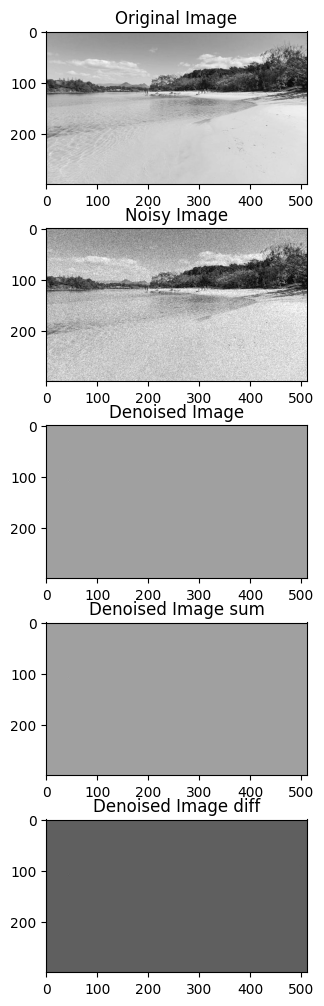

In [12]:
#imgOriginal = cv2.imread(originalImgs[1],0)
#imgNoisy = cv2.imread(noisyImgs[1],0)
#imgReconstructed = denoise_image_icm_bmrf(imgNoisy)
fig, axes = plt.subplots(5,1,figsize=(10,10))
fig.tight_layout()
axes[0].imshow(imgOriginal,cmap="gray")
axes[0].set_title('Original Image')
axes[1].imshow(imgNoisy,cmap="gray")
axes[1].set_title('Noisy Image')
axes[2].imshow(imgReconstructed, cmap="gray")
axes[2].set_title('Denoised Image')
axes[3].imshow((imgNoisy+imgReconstructed), cmap="gray")
axes[3].set_title('Denoised Image sum')
axes[4].imshow((imgNoisy-imgReconstructed), cmap="gray")
axes[4].set_title('Denoised Image diff')
plt.show()